# Divergence: Analysis of Load Difference Time Series

This notebook analyzes the time-series of the annual mean difference in load projections across pairs of IM3 scenarios. The analysis is initially done at the state level but could readily be expanded to work on balancing authorities as well.

In [1]:
# Start by importing the packages we need:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd

from glob import glob
from mpl_toolkits.axes_grid1 import make_axes_locatable


## Set the Directory Structure

In [2]:
# Identify the data input and output directories:
data_input_dir =  '/Users/burl878/Documents/IMMM/Data/TELL/Production_Runs/tell_data/outputs/tell_output/'
data_output_dir =  '/Users/burl878/Documents/Code/code_repos/exp_group_b_test/analyses/data/'
image_output_dir =  '/Users/burl878/Documents/Code/code_repos/exp_group_b_test/analyses/plots/load_difference_time_series/'

# If the "image_output_dir" subdirectory doesn't exist then create it:
if not os.path.exists(image_output_dir):
   os.makedirs(image_output_dir)


## Process the Annual Mean Load Difference

In [3]:
# Define a function to calculate the annual mean load difference between 'scenario_one' and 'scenario_two':
def process_load_difference_time_series(data_input_dir: str, process_states: bool, scenario_one: str, scenario_two: str):
    #Initiate a counter to store the results:
    counter = 0;
    output_df = pd.DataFrame()
    
    # Loop over the years from 2020 to 2095 in 5 year increments:
    for year in range(2020,2099,5):
        if process_states == True:
           # Read in the state-level time series for 'scenario_one':
           df_one = pd.read_csv(data_input_dir + scenario_one + '/' + str(year) + '/TELL_State_Hourly_Load_Data_' + str(year) + '_Scaled_' + str(year) + '.csv')
            
           # Rename a few columns for simplicity:
           df_one.rename(columns={'Scaled_TELL_State_Load_MWh': 'load_one', 'State_Name': 'name', 'Time_UTC': 'time'}, inplace=True)
        
           # Only keep the columns that are needed:
           df_one = df_one[['name', 'time', 'load_one']].copy()
        
           # Read in the state-level time series for 'scenario_two':
           df_two = pd.read_csv(data_input_dir + scenario_two + '/' + str(year) + '/TELL_State_Hourly_Load_Data_' + str(year) + '_Scaled_' + str(year) + '.csv')
            
           # Rename a few columns for simplicity:
           df_two.rename(columns={'Scaled_TELL_State_Load_MWh': 'load_two', 'State_Name': 'name', 'Time_UTC': 'time'}, inplace=True)
        
           # Only keep the columns that are needed:
           df_two = df_two[['name', 'time', 'load_two']].copy()
           
           # Merge the two time series together on state name and time:
           merged_df = df_one.merge(df_two, on=['name', 'time'])
            
        if process_states == False:
           # Read in the BA-level time series for 'scenario_one':
           df_one = pd.read_csv(data_input_dir + scenario_one + '/' + str(year) + '/TELL_Balancing_Authority_Hourly_Load_Data_' + str(year) + '_Scaled_' + str(year) + '.csv')
            
           # Rename a few columns for simplicity:
           df_one.rename(columns={'Scaled_TELL_BA_Load_MWh': 'load_one', 'BA_Code': 'name', 'Time_UTC': 'time'}, inplace=True)
        
           # Only keep the columns that are needed:
           df_one = df_one[['name', 'time', 'load_one']].copy()    
           
           # Read in the BA-level time series for 'scenario_two':
           df_two = pd.read_csv(data_input_dir + scenario_two + '/' + str(year) + '/TELL_Balancing_Authority_Hourly_Load_Data_' + str(year) + '_Scaled_' + str(year) + '.csv')
            
           # Rename a few columns for simplicity:
           df_two.rename(columns={'Scaled_TELL_BA_Load_MWh': 'load_two', 'BA_Code': 'name', 'Time_UTC': 'time'}, inplace=True)
        
           # Only keep the columns that are needed:
           df_two = df_two[['name', 'time', 'load_two']].copy()   
           
           # Merge the two time series together on BA name and time:
           merged_df = df_one.merge(df_two, on=['name', 'time'])
           
        # Calculate the mean load between the two time-series as well as the absolute and relative load biases:
        merged_df['mean_load'] =  merged_df[['load_one', 'load_two']].mean(axis=1)
        merged_df['absolute_difference'] = abs(merged_df['load_one'] - merged_df['load_two'])
        merged_df['relative_difference'] = 100*(merged_df['absolute_difference']/merged_df['mean_load']).round(4)
       
        # Make a list of all of the states or BAs in the 'merged_df':
        entities = merged_df['name'].unique()
         
        # Loop over the entities and calculate the mean bias for each entity:
        for i in range(len(entities)):
            # Iterate the counter by one:
            counter = counter + 1
            
            # Subset to just the data for the entity being processed:
            subset_df = merged_df[merged_df['name'].isin([entities[i]])].copy()
          
            # Subset to the top 10% of all mean load hours:
            peak_df = subset_df.nlargest(876,'mean_load')
        
            # Put the output in a new dataframe:
            output_df.loc[counter, 'Year'] = str(year)
            output_df.loc[counter, 'Name'] = entities[i]
            output_df.loc[counter, 'Mean_Abs_Diff_MWh'] = subset_df['absolute_difference'].mean().round(2)
            output_df.loc[counter, 'Mean_Rel_Diff_%'] = subset_df['relative_difference'].mean().round(2)
            output_df.loc[counter, 'Peak_Abs_Diff_MWh'] = peak_df['absolute_difference'].mean().round(2)
            output_df.loc[counter, 'Peak_Rel_Diff_%'] = peak_df['relative_difference'].mean().round(2)
        
            # Clean up and move to the next step in the loop:
            del subset_df, peak_df
    
    # Generate the .csv output file name:
    if process_states == True:
       csv_output_filename = os.path.join(data_output_dir, 'State_Differences_' + scenario_one + '_Versus_' + scenario_two + '.csv')
    if process_states == False:
       csv_output_filename = os.path.join(data_output_dir, 'BA_Differences_' + scenario_one + '_Versus_' + scenario_two + '.csv')

    # Write out the dataframe to a .csv file:
    output_df.to_csv(csv_output_filename, sep=',', index=False)
    
    return output_df


In [ ]:
# Set the groups of scenarios to plot:
ssp_div_a_one = 'rcp45cooler_ssp5'; ssp_div_a_two = 'rcp45cooler_ssp3';
ssp_div_b_one = 'rcp45hotter_ssp5'; ssp_div_b_two = 'rcp45hotter_ssp3';
ssp_div_c_one = 'rcp85cooler_ssp5'; ssp_div_c_two = 'rcp85cooler_ssp3';
ssp_div_d_one = 'rcp85hotter_ssp5'; ssp_div_d_two = 'rcp85hotter_ssp3';
  
rcp_div_a_one = 'rcp85cooler_ssp3'; rcp_div_a_two = 'rcp45cooler_ssp3'; 
rcp_div_b_one = 'rcp85hotter_ssp3'; rcp_div_b_two = 'rcp45hotter_ssp3'; 
rcp_div_c_one = 'rcp85cooler_ssp5'; rcp_div_c_two = 'rcp45cooler_ssp5'; 
rcp_div_d_one = 'rcp85hotter_ssp5'; rcp_div_d_two = 'rcp45hotter_ssp5';
    
gcm_div_a_one = 'rcp45hotter_ssp3'; gcm_div_a_two = 'rcp45cooler_ssp3'; 
gcm_div_b_one = 'rcp45hotter_ssp5'; gcm_div_b_two = 'rcp45cooler_ssp5'; 
gcm_div_c_one = 'rcp85hotter_ssp3'; gcm_div_c_two = 'rcp85cooler_ssp3'; 
gcm_div_d_one = 'rcp85hotter_ssp5'; gcm_div_d_two = 'rcp85cooler_ssp5';

# Process the load time series for each pair of scenarios
output_df = process_load_difference_time_series(data_input_dir = data_input_dir, 
                                                process_states = True, 
                                                scenario_one = ssp_div_a_one, 
                                                scenario_two = ssp_div_a_two)

output_df


In [4]:
# Define a function to calculate the point of divergence across all scenario combinations
def process_point_of_divergence(data_input_dir: str, process_states: bool, threshold: int):
    #Initiate a counter to store the results:
    counter = 0;
    output_df = pd.DataFrame()
    
    # Create a list of all files in the input directory:
    if process_states == True:
       list_of_files = glob(f'{data_input_dir}State_Differences*.csv')
    if process_states == False:
       list_of_files = glob(f'{data_input_dir}BA_Differences*.csv')  
    
    # Loop over the list of files and compute the point of divergence for each entity:
    for file in range(len(list_of_files)):
        # Read in the .csv file:
        df = pd.read_csv(list_of_files[file])
    
        # Extract the scenarios from the filename:
        if process_states == True:
           filename = str(os.path.splitext(os.path.basename(list_of_files[file]))[0]).replace('_Versus', '_').replace('State_Differences_', '')
        if process_states == False:
           filename = str(os.path.splitext(os.path.basename(list_of_files[file]))[0]).replace('_Versus', '_').replace('BA_Differences_', '')
        scenario_one = filename.split('__')[0]
        scenario_two = filename.split('__')[1]
    
        # Make a list of all of the states or BAs in the 'merged_df':
        entities = df['Name'].unique()
         
        # Loop over the entities and calculate the point of divergence for each entity:
        for i in range(len(entities)):
            # Iterate the counter by one:
            counter = counter + 1
            
            # Subset to just the data for the entity being processed:
            subset_df = df[df['Name'].isin([entities[i]])].copy()
            
            # Initiate empty break year and break values:
            mean_break_year = np.nan
            mean_break_value = np.nan
            peak_break_year = np.nan
            peak_break_value = np.nan
                
            # Loop over the rows of the dataframe and check if the mean value in the row exceeds the threshold value:
            for row in range(len(subset_df)-1):
                # If the difference in the year and the following year exceeds the threshold value then stop the loop and output the results:
                if (subset_df['Mean_Rel_Diff_%'].iloc[row] >= threshold) & (subset_df['Mean_Rel_Diff_%'].iloc[row+1] >= threshold):
                    mean_break_year = subset_df['Year'].iloc[row]
                    mean_break_value = subset_df['Mean_Rel_Diff_%'].iloc[row]
                    break
            
            # Loop over the rows of the dataframe and check if the peak value in the row exceeds the threshold value:
            for row in range(len(subset_df)-1):
                # If the difference in the year and the following year exceeds the threshold value then stop the loop and output the results:
                if (subset_df['Peak_Rel_Diff_%'].iloc[row] >= threshold) & (subset_df['Peak_Rel_Diff_%'].iloc[row+1] >= threshold):
                    peak_break_year = subset_df['Year'].iloc[row]
                    peak_break_value = subset_df['Peak_Rel_Diff_%'].iloc[row]
                    break

            # Put the output in a new dataframe:
            output_df.loc[counter, 'Name'] = entities[i]
            output_df.loc[counter, 'Scenario_One'] = scenario_one
            output_df.loc[counter, 'Scenario_Two'] = scenario_two
            output_df.loc[counter, 'Mean_Break_Year'] = mean_break_year
            output_df.loc[counter, 'Mean_Break_Value_%'] = mean_break_value
            output_df.loc[counter, 'Peak_Break_Year'] = peak_break_year
            output_df.loc[counter, 'Peak_Break_Value_%'] = peak_break_value
            
            # Clean up:
            del subset_df, row, mean_break_year, mean_break_value, peak_break_year, peak_break_value
        
        # Clean up:
        del df, filename, scenario_one, scenario_two, i, entities
    
    # Generate the .csv output file name:
    if process_states == True:
       csv_output_filename = os.path.join(data_output_dir, 'State_Divergence_Years_' + str(threshold) + '.csv')
    if process_states == False:
       csv_output_filename = os.path.join(data_output_dir, 'BA_Divergence_Years_' + str(threshold) + '.csv')

    # Write out the dataframe to a .csv file:
    output_df.to_csv(csv_output_filename, sep=',', index=False)
    
    return output_df


In [ ]:
output_df = process_point_of_divergence(data_input_dir = data_output_dir, 
                                        process_states = True, 
                                        threshold = 10)

output_df


## Make the Plots

In [6]:
# Define a function to plot the time series for a single entity:
def plot_entity_point_of_divergence(data_input_dir: str, entity: str, process_states: bool, image_output_dir: str, image_resolution: int, save_images=False):
    
    # Set the groups of scenarios to plot:
    ssp_div_a_one = 'rcp45cooler_ssp5'; ssp_div_a_two = 'rcp45cooler_ssp3';
    ssp_div_b_one = 'rcp45hotter_ssp5'; ssp_div_b_two = 'rcp45hotter_ssp3';
    ssp_div_c_one = 'rcp85cooler_ssp5'; ssp_div_c_two = 'rcp85cooler_ssp3';
    ssp_div_d_one = 'rcp85hotter_ssp5'; ssp_div_d_two = 'rcp85hotter_ssp3';
    
    rcp_div_a_one = 'rcp85cooler_ssp3'; rcp_div_a_two = 'rcp45cooler_ssp3'; 
    rcp_div_b_one = 'rcp85hotter_ssp3'; rcp_div_b_two = 'rcp45hotter_ssp3'; 
    rcp_div_c_one = 'rcp85cooler_ssp5'; rcp_div_c_two = 'rcp45cooler_ssp5'; 
    rcp_div_d_one = 'rcp85hotter_ssp5'; rcp_div_d_two = 'rcp45hotter_ssp5';
    
    gcm_div_a_one = 'rcp45hotter_ssp3'; gcm_div_a_two = 'rcp45cooler_ssp3'; 
    gcm_div_b_one = 'rcp45hotter_ssp5'; gcm_div_b_two = 'rcp45cooler_ssp5'; 
    gcm_div_c_one = 'rcp85hotter_ssp3'; gcm_div_c_two = 'rcp85cooler_ssp3'; 
    gcm_div_d_one = 'rcp85hotter_ssp5'; gcm_div_d_two = 'rcp85cooler_ssp5';
    
    # Load in the time series:
    if process_states == True:
       ssp_div_a_df = pd.read_csv(data_input_dir + 'State_Differences_' + ssp_div_a_one + '_Versus_' + ssp_div_a_two + '.csv'); ssp_div_a_df = ssp_div_a_df[ssp_div_a_df['Name'].isin([entity])]
       ssp_div_b_df = pd.read_csv(data_input_dir + 'State_Differences_' + ssp_div_b_one + '_Versus_' + ssp_div_b_two + '.csv'); ssp_div_b_df = ssp_div_b_df[ssp_div_b_df['Name'].isin([entity])]
       ssp_div_c_df = pd.read_csv(data_input_dir + 'State_Differences_' + ssp_div_c_one + '_Versus_' + ssp_div_c_two + '.csv'); ssp_div_c_df = ssp_div_c_df[ssp_div_c_df['Name'].isin([entity])]
       ssp_div_d_df = pd.read_csv(data_input_dir + 'State_Differences_' + ssp_div_d_one + '_Versus_' + ssp_div_d_two + '.csv'); ssp_div_d_df = ssp_div_d_df[ssp_div_d_df['Name'].isin([entity])] 
        
       rcp_div_a_df = pd.read_csv(data_input_dir + 'State_Differences_' + rcp_div_a_one + '_Versus_' + rcp_div_a_two + '.csv'); rcp_div_a_df = rcp_div_a_df[rcp_div_a_df['Name'].isin([entity])]
       rcp_div_b_df = pd.read_csv(data_input_dir + 'State_Differences_' + rcp_div_b_one + '_Versus_' + rcp_div_b_two + '.csv'); rcp_div_b_df = rcp_div_b_df[rcp_div_b_df['Name'].isin([entity])]
       rcp_div_c_df = pd.read_csv(data_input_dir + 'State_Differences_' + rcp_div_c_one + '_Versus_' + rcp_div_c_two + '.csv'); rcp_div_c_df = rcp_div_c_df[rcp_div_c_df['Name'].isin([entity])]
       rcp_div_d_df = pd.read_csv(data_input_dir + 'State_Differences_' + rcp_div_d_one + '_Versus_' + rcp_div_d_two + '.csv'); rcp_div_d_df = rcp_div_d_df[rcp_div_d_df['Name'].isin([entity])] 
    
       gcm_div_a_df = pd.read_csv(data_input_dir + 'State_Differences_' + gcm_div_a_one + '_Versus_' + gcm_div_a_two + '.csv'); gcm_div_a_df = gcm_div_a_df[gcm_div_a_df['Name'].isin([entity])]
       gcm_div_b_df = pd.read_csv(data_input_dir + 'State_Differences_' + gcm_div_b_one + '_Versus_' + gcm_div_b_two + '.csv'); gcm_div_b_df = gcm_div_b_df[gcm_div_b_df['Name'].isin([entity])]
       gcm_div_c_df = pd.read_csv(data_input_dir + 'State_Differences_' + gcm_div_c_one + '_Versus_' + gcm_div_c_two + '.csv'); gcm_div_c_df = gcm_div_c_df[gcm_div_c_df['Name'].isin([entity])]
       gcm_div_d_df = pd.read_csv(data_input_dir + 'State_Differences_' + gcm_div_d_one + '_Versus_' + gcm_div_d_two + '.csv'); gcm_div_d_df = gcm_div_d_df[gcm_div_d_df['Name'].isin([entity])] 
    
    if process_states == False:
       ssp_div_a_df = pd.read_csv(data_input_dir + 'BA_Differences_' + ssp_div_a_one + '_Versus_' + ssp_div_a_two + '.csv'); ssp_div_a_df = ssp_div_a_df[ssp_div_a_df['Name'].isin([entity])]
       ssp_div_b_df = pd.read_csv(data_input_dir + 'BA_Differences_' + ssp_div_b_one + '_Versus_' + ssp_div_b_two + '.csv'); ssp_div_b_df = ssp_div_b_df[ssp_div_b_df['Name'].isin([entity])]
       ssp_div_c_df = pd.read_csv(data_input_dir + 'BA_Differences_' + ssp_div_c_one + '_Versus_' + ssp_div_c_two + '.csv'); ssp_div_c_df = ssp_div_c_df[ssp_div_c_df['Name'].isin([entity])]
       ssp_div_d_df = pd.read_csv(data_input_dir + 'BA_Differences_' + ssp_div_d_one + '_Versus_' + ssp_div_d_two + '.csv'); ssp_div_d_df = ssp_div_d_df[ssp_div_d_df['Name'].isin([entity])] 
       
       rcp_div_a_df = pd.read_csv(data_input_dir + 'BA_Differences_' + rcp_div_a_one + '_Versus_' + rcp_div_a_two + '.csv'); rcp_div_a_df = rcp_div_a_df[rcp_div_a_df['Name'].isin([entity])]
       rcp_div_b_df = pd.read_csv(data_input_dir + 'BA_Differences_' + rcp_div_b_one + '_Versus_' + rcp_div_b_two + '.csv'); rcp_div_b_df = rcp_div_b_df[rcp_div_b_df['Name'].isin([entity])]
       rcp_div_c_df = pd.read_csv(data_input_dir + 'BA_Differences_' + rcp_div_c_one + '_Versus_' + rcp_div_c_two + '.csv'); rcp_div_c_df = rcp_div_c_df[rcp_div_c_df['Name'].isin([entity])]
       rcp_div_d_df = pd.read_csv(data_input_dir + 'BA_Differences_' + rcp_div_d_one + '_Versus_' + rcp_div_d_two + '.csv'); rcp_div_d_df = rcp_div_d_df[rcp_div_d_df['Name'].isin([entity])] 
     
       gcm_div_a_df = pd.read_csv(data_input_dir + 'BA_Differences_' + gcm_div_a_one + '_Versus_' + gcm_div_a_two + '.csv'); gcm_div_a_df = gcm_div_a_df[gcm_div_a_df['Name'].isin([entity])]
       gcm_div_b_df = pd.read_csv(data_input_dir + 'BA_Differences_' + gcm_div_b_one + '_Versus_' + gcm_div_b_two + '.csv'); gcm_div_b_df = gcm_div_b_df[gcm_div_b_df['Name'].isin([entity])]
       gcm_div_c_df = pd.read_csv(data_input_dir + 'BA_Differences_' + gcm_div_c_one + '_Versus_' + gcm_div_c_two + '.csv'); gcm_div_c_df = gcm_div_c_df[gcm_div_c_df['Name'].isin([entity])]
       gcm_div_d_df = pd.read_csv(data_input_dir + 'BA_Differences_' + gcm_div_d_one + '_Versus_' + gcm_div_d_two + '.csv'); gcm_div_d_df = gcm_div_d_df[gcm_div_d_df['Name'].isin([entity])]
    
    # Make the plot:
    plt.figure(figsize=(24, 15))
    plt.rcParams['font.size'] = 16
    
    plt.subplot(221)
    plt.plot(-5, 0, color='k', linestyle='-', label='Mean Load Difference', linewidth=2)
    plt.plot(-5, 0, color='k', linestyle=':', label='Peak Load Difference', linewidth=2)
    plt.plot(ssp_div_a_df['Year'], ssp_div_a_df['Mean_Rel_Diff_%'], color='b', linestyle='-', label=(ssp_div_a_one + ' vs ' + ssp_div_a_two), linewidth=2)
    plt.plot(ssp_div_b_df['Year'], ssp_div_b_df['Mean_Rel_Diff_%'], color='cyan', linestyle='-', label=(ssp_div_b_one + ' vs ' + ssp_div_b_two), linewidth=2)
    plt.plot(ssp_div_c_df['Year'], ssp_div_c_df['Mean_Rel_Diff_%'], color='orange', linestyle='-', label=(ssp_div_c_one + ' vs ' + ssp_div_c_two), linewidth=2)
    plt.plot(ssp_div_d_df['Year'], ssp_div_d_df['Mean_Rel_Diff_%'], color='r', linestyle='-', label=(ssp_div_d_one + ' vs ' + ssp_div_d_two), linewidth=2)
    plt.plot(ssp_div_a_df['Year'], ssp_div_a_df['Peak_Rel_Diff_%'], color='b', linestyle=':', linewidth=2)
    plt.plot(ssp_div_b_df['Year'], ssp_div_b_df['Peak_Rel_Diff_%'], color='cyan', linestyle=':', linewidth=2)
    plt.plot(ssp_div_c_df['Year'], ssp_div_c_df['Peak_Rel_Diff_%'], color='orange', linestyle=':', linewidth=2)
    plt.plot(ssp_div_d_df['Year'], ssp_div_d_df['Peak_Rel_Diff_%'], color='r', linestyle=':', linewidth=2)
    plt.xlim([2020, 2095]); plt.ylim(bottom=0)
    plt.grid(True)
    plt.legend(loc='upper left', prop={'size': 14})
    plt.xlabel('Year'); plt.ylabel('Annual Mean Hourly Load Difference [%]')
    plt.title(('Socioeconomic Scenario Divergence [SSP3 vs SSP5]: ' + entity))
    
    plt.subplot(222)
    plt.plot(-5, 0, color='k', linestyle='-', label='Mean Load Difference', linewidth=2)
    plt.plot(-5, 0, color='k', linestyle=':', label='Peak Load Difference', linewidth=2)
    plt.plot(rcp_div_a_df['Year'], rcp_div_a_df['Mean_Rel_Diff_%'], color='forestgreen', linestyle='-', label=(rcp_div_a_one + ' vs ' + rcp_div_a_two), linewidth=2)
    plt.plot(rcp_div_b_df['Year'], rcp_div_b_df['Mean_Rel_Diff_%'], color='blueviolet', linestyle='-', label=(rcp_div_b_one + ' vs ' + rcp_div_b_two), linewidth=2)
    plt.plot(rcp_div_c_df['Year'], rcp_div_c_df['Mean_Rel_Diff_%'], color='goldenrod', linestyle='-', label=(rcp_div_c_one + ' vs ' + rcp_div_c_two), linewidth=2)
    plt.plot(rcp_div_d_df['Year'], rcp_div_d_df['Mean_Rel_Diff_%'], color='lightcoral', linestyle='-', label=(rcp_div_d_one + ' vs ' + rcp_div_d_two), linewidth=2)
    plt.plot(rcp_div_a_df['Year'], rcp_div_a_df['Peak_Rel_Diff_%'], color='forestgreen', linestyle=':', linewidth=2)
    plt.plot(rcp_div_b_df['Year'], rcp_div_b_df['Peak_Rel_Diff_%'], color='blueviolet', linestyle=':', linewidth=2)
    plt.plot(rcp_div_c_df['Year'], rcp_div_c_df['Peak_Rel_Diff_%'], color='goldenrod', linestyle=':', linewidth=2)
    plt.plot(rcp_div_d_df['Year'], rcp_div_d_df['Peak_Rel_Diff_%'], color='lightcoral', linestyle=':', linewidth=2)
    plt.xlim([2020, 2095]); plt.ylim(bottom=0)
    plt.grid(True)
    plt.legend(loc='upper left', prop={'size': 14})
    plt.xlabel('Year'); plt.ylabel('Annual Mean Hourly Load Difference [%]')
    plt.title(('Climate Scenario Divergence [RCP 4.5 vs RCP 8.5]: ' + entity))
    
    plt.subplot(223)
    plt.plot(-5, 0, color='k', linestyle='-', label='Mean Load Difference', linewidth=2)
    plt.plot(-5, 0, color='k', linestyle=':', label='Peak Load Difference', linewidth=2)
    plt.plot(gcm_div_a_df['Year'], gcm_div_a_df['Mean_Rel_Diff_%'], color='brown', linestyle='-', label=(gcm_div_a_one + ' vs ' + gcm_div_a_two), linewidth=2)
    plt.plot(gcm_div_b_df['Year'], gcm_div_b_df['Mean_Rel_Diff_%'], color='gold', linestyle='-', label=(gcm_div_b_one + ' vs ' + gcm_div_b_two), linewidth=2)
    plt.plot(gcm_div_c_df['Year'], gcm_div_c_df['Mean_Rel_Diff_%'], color='skyblue', linestyle='-', label=(gcm_div_c_one + ' vs ' + gcm_div_c_two), linewidth=2)
    plt.plot(gcm_div_d_df['Year'], gcm_div_d_df['Mean_Rel_Diff_%'], color='magenta', linestyle='-', label=(gcm_div_d_one + ' vs ' + gcm_div_d_two), linewidth=2)
    plt.plot(gcm_div_a_df['Year'], gcm_div_a_df['Peak_Rel_Diff_%'], color='brown', linestyle=':', linewidth=2)
    plt.plot(gcm_div_b_df['Year'], gcm_div_b_df['Peak_Rel_Diff_%'], color='gold', linestyle=':', linewidth=2)
    plt.plot(gcm_div_c_df['Year'], gcm_div_c_df['Peak_Rel_Diff_%'], color='skyblue', linestyle=':', linewidth=2)
    plt.plot(gcm_div_d_df['Year'], gcm_div_d_df['Peak_Rel_Diff_%'], color='magenta', linestyle=':', linewidth=2)
    plt.xlim([2020, 2095]); plt.ylim(bottom=0)
    plt.grid(True)
    plt.legend(loc='upper left', prop={'size': 14})
    plt.xlabel('Year'); plt.ylabel('Annual Mean Hourly Load Difference [%]')
    plt.title(('Climate Model Divergence [Hotter vs Colder Models]: ' + entity))
    
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       if process_states == True:
          filename = ('State_' + entity.replace(" ", "_") + '_Load_Divergence.png')
       if process_states == False:
          filename = ('BA_' + entity.replace(" ", "_") + '_Load_Divergence.png')
       plt.savefig(os.path.join(image_output_dir, filename), dpi=image_resolution, bbox_inches='tight', facecolor='white')


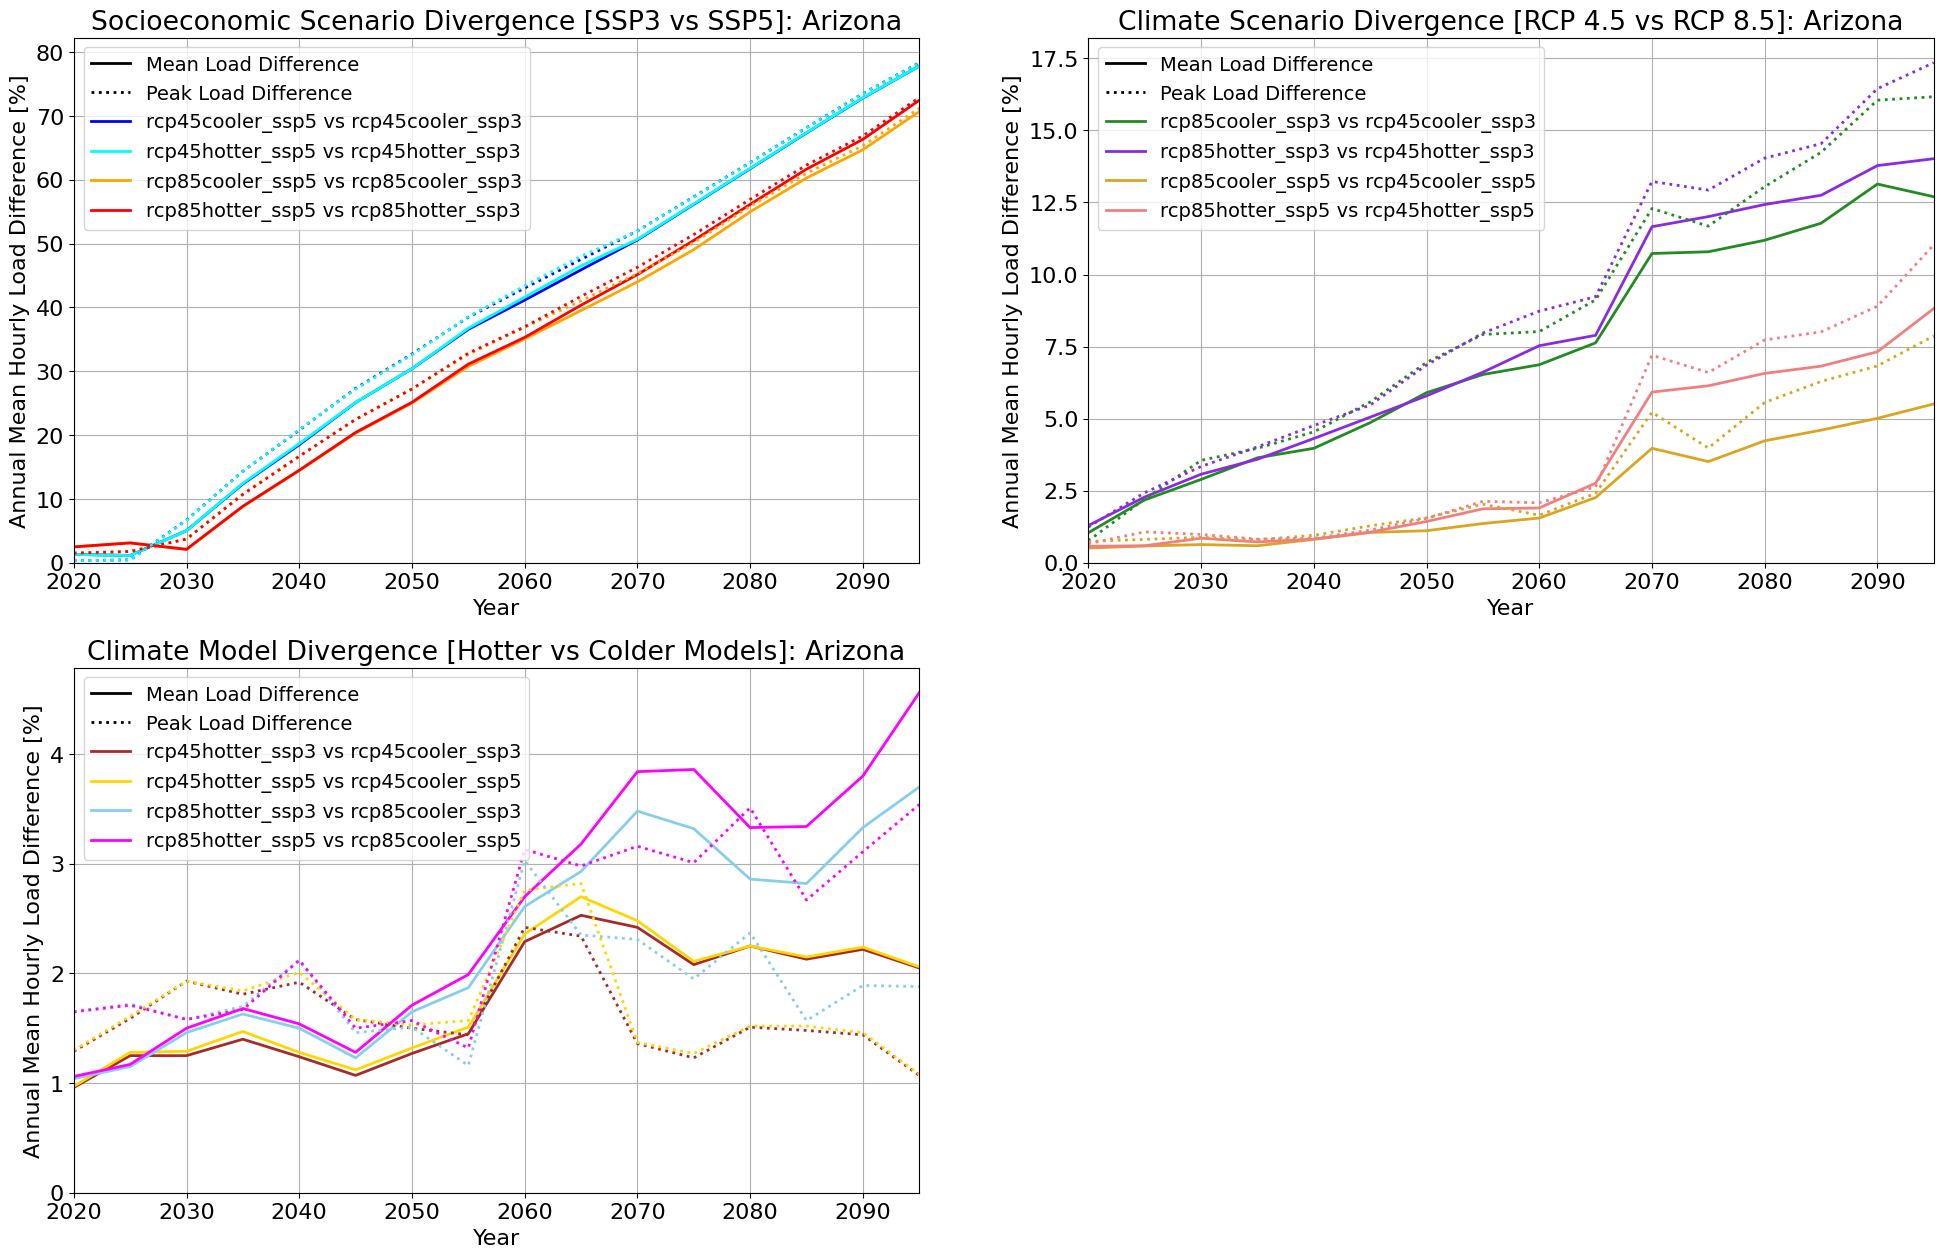

In [7]:
plot_entity_point_of_divergence(data_input_dir = data_output_dir, 
                                entity = 'Arizona', 
                                process_states = True,
                                image_output_dir = image_output_dir, 
                                image_resolution = 300, 
                                save_images = True)


In [6]:
# Define a function to plot the change point distribution for all states or BAs:
def plot_group_point_of_divergence(data_input_dir: str, threshold: int, process_states: bool, image_output_dir: str, image_resolution: int, save_images=False):
    
    # Set the groups of scenarios to plot:
    ssp_div_a_one = 'rcp45cooler_ssp5'; ssp_div_a_two = 'rcp45cooler_ssp3';
    ssp_div_b_one = 'rcp45hotter_ssp5'; ssp_div_b_two = 'rcp45hotter_ssp3';
    ssp_div_c_one = 'rcp85cooler_ssp5'; ssp_div_c_two = 'rcp85cooler_ssp3';
    ssp_div_d_one = 'rcp85hotter_ssp5'; ssp_div_d_two = 'rcp85hotter_ssp3';
    
    rcp_div_a_one = 'rcp85cooler_ssp3'; rcp_div_a_two = 'rcp45cooler_ssp3'; 
    rcp_div_b_one = 'rcp85hotter_ssp3'; rcp_div_b_two = 'rcp45hotter_ssp3'; 
    rcp_div_c_one = 'rcp85cooler_ssp5'; rcp_div_c_two = 'rcp45cooler_ssp5'; 
    rcp_div_d_one = 'rcp85hotter_ssp5'; rcp_div_d_two = 'rcp45hotter_ssp5';
    
    gcm_div_a_one = 'rcp45hotter_ssp3'; gcm_div_a_two = 'rcp45cooler_ssp3'; 
    gcm_div_b_one = 'rcp45hotter_ssp5'; gcm_div_b_two = 'rcp45cooler_ssp5'; 
    gcm_div_c_one = 'rcp85hotter_ssp3'; gcm_div_c_two = 'rcp85cooler_ssp3'; 
    gcm_div_d_one = 'rcp85hotter_ssp5'; gcm_div_d_two = 'rcp85cooler_ssp5';
    
    # Load in the time series:
    if process_states == True:
       div_df = pd.read_csv(data_input_dir + 'State_Divergence_Years_' + str(threshold) + '.csv') 
    if process_states == False:
       div_df = pd.read_csv(data_input_dir + 'BA_Divergence_Years_' + str(threshold) + '.csv') 
    
    counter = 0; ssp_div_a = pd.DataFrame(); subset_df = div_df.loc[(div_df['Scenario_One'] == ssp_div_a_one) & (div_df['Scenario_Two'] == ssp_div_a_two)]
    for year in range(2020,2099,5):
        counter = counter + 1;
        ssp_div_a.loc[counter, 'Year'] = year;
        ssp_div_a.loc[counter, 'Mean_Breaks'] = (subset_df.loc[subset_df['Mean_Break_Year'] <= year]).shape[0]
        ssp_div_a.loc[counter, 'Peak_Breaks'] = (subset_df.loc[subset_df['Peak_Break_Year'] <= year]).shape[0]
    del counter, subset_df, year
    
    counter = 0; ssp_div_b = pd.DataFrame(); subset_df = div_df.loc[(div_df['Scenario_One'] == ssp_div_b_one) & (div_df['Scenario_Two'] == ssp_div_b_two)]
    for year in range(2020,2099,5):
        counter = counter + 1;
        ssp_div_b.loc[counter, 'Year'] = year;
        ssp_div_b.loc[counter, 'Mean_Breaks'] = (subset_df.loc[subset_df['Mean_Break_Year'] <= year]).shape[0]
        ssp_div_b.loc[counter, 'Peak_Breaks'] = (subset_df.loc[subset_df['Peak_Break_Year'] <= year]).shape[0]
    del counter, subset_df, year
       
    counter = 0; ssp_div_c = pd.DataFrame(); subset_df = div_df.loc[(div_df['Scenario_One'] == ssp_div_c_one) & (div_df['Scenario_Two'] == ssp_div_c_two)]
    for year in range(2020,2099,5):
        counter = counter + 1;
        ssp_div_c.loc[counter, 'Year'] = year;
        ssp_div_c.loc[counter, 'Mean_Breaks'] = (subset_df.loc[subset_df['Mean_Break_Year'] <= year]).shape[0]
        ssp_div_c.loc[counter, 'Peak_Breaks'] = (subset_df.loc[subset_df['Peak_Break_Year'] <= year]).shape[0]
    del counter, subset_df, year
    
    counter = 0; ssp_div_d = pd.DataFrame(); subset_df = div_df.loc[(div_df['Scenario_One'] == ssp_div_d_one) & (div_df['Scenario_Two'] == ssp_div_d_two)]
    for year in range(2020,2099,5):
        counter = counter + 1;
        ssp_div_d.loc[counter, 'Year'] = year;
        ssp_div_d.loc[counter, 'Mean_Breaks'] = (subset_df.loc[subset_df['Mean_Break_Year'] <= year]).shape[0]
        ssp_div_d.loc[counter, 'Peak_Breaks'] = (subset_df.loc[subset_df['Peak_Break_Year'] <= year]).shape[0]
    del counter, subset_df, year

    counter = 0; rcp_div_a = pd.DataFrame(); subset_df = div_df.loc[(div_df['Scenario_One'] == rcp_div_a_one) & (div_df['Scenario_Two'] == rcp_div_a_two)]
    for year in range(2020,2099,5):
        counter = counter + 1;
        rcp_div_a.loc[counter, 'Year'] = year;
        rcp_div_a.loc[counter, 'Mean_Breaks'] = (subset_df.loc[subset_df['Mean_Break_Year'] <= year]).shape[0]
        rcp_div_a.loc[counter, 'Peak_Breaks'] = (subset_df.loc[subset_df['Peak_Break_Year'] <= year]).shape[0]
    del counter, subset_df, year
    
    counter = 0; rcp_div_b = pd.DataFrame(); subset_df = div_df.loc[(div_df['Scenario_One'] == rcp_div_b_one) & (div_df['Scenario_Two'] == rcp_div_b_two)]
    for year in range(2020,2099,5):
        counter = counter + 1;
        rcp_div_b.loc[counter, 'Year'] = year;
        rcp_div_b.loc[counter, 'Mean_Breaks'] = (subset_df.loc[subset_df['Mean_Break_Year'] <= year]).shape[0]
        rcp_div_b.loc[counter, 'Peak_Breaks'] = (subset_df.loc[subset_df['Peak_Break_Year'] <= year]).shape[0]
    del counter, subset_df, year
    
    counter = 0; rcp_div_c = pd.DataFrame(); subset_df = div_df.loc[(div_df['Scenario_One'] == rcp_div_c_one) & (div_df['Scenario_Two'] == rcp_div_c_two)]
    for year in range(2020,2099,5):
        counter = counter + 1;
        rcp_div_c.loc[counter, 'Year'] = year;
        rcp_div_c.loc[counter, 'Mean_Breaks'] = (subset_df.loc[subset_df['Mean_Break_Year'] <= year]).shape[0]
        rcp_div_c.loc[counter, 'Peak_Breaks'] = (subset_df.loc[subset_df['Peak_Break_Year'] <= year]).shape[0]
    del counter, subset_df, year
    
    counter = 0; rcp_div_d = pd.DataFrame(); subset_df = div_df.loc[(div_df['Scenario_One'] == rcp_div_d_one) & (div_df['Scenario_Two'] == rcp_div_d_two)]
    for year in range(2020,2099,5):
        counter = counter + 1;
        rcp_div_d.loc[counter, 'Year'] = year;
        rcp_div_d.loc[counter, 'Mean_Breaks'] = (subset_df.loc[subset_df['Mean_Break_Year'] <= year]).shape[0]
        rcp_div_d.loc[counter, 'Peak_Breaks'] = (subset_df.loc[subset_df['Peak_Break_Year'] <= year]).shape[0]
    del counter, subset_df, year
    
    counter = 0; gcm_div_a = pd.DataFrame(); subset_df = div_df.loc[(div_df['Scenario_One'] == gcm_div_a_one) & (div_df['Scenario_Two'] == gcm_div_a_two)]
    for year in range(2020,2099,5):
        counter = counter + 1;
        gcm_div_a.loc[counter, 'Year'] = year;
        gcm_div_a.loc[counter, 'Mean_Breaks'] = (subset_df.loc[subset_df['Mean_Break_Year'] <= year]).shape[0]
        gcm_div_a.loc[counter, 'Peak_Breaks'] = (subset_df.loc[subset_df['Peak_Break_Year'] <= year]).shape[0]
    del counter, subset_df, year
    
    counter = 0; gcm_div_b = pd.DataFrame(); subset_df = div_df.loc[(div_df['Scenario_One'] == gcm_div_b_one) & (div_df['Scenario_Two'] == gcm_div_b_two)]
    for year in range(2020,2099,5):
        counter = counter + 1;
        gcm_div_b.loc[counter, 'Year'] = year;
        gcm_div_b.loc[counter, 'Mean_Breaks'] = (subset_df.loc[subset_df['Mean_Break_Year'] <= year]).shape[0]
        gcm_div_b.loc[counter, 'Peak_Breaks'] = (subset_df.loc[subset_df['Peak_Break_Year'] <= year]).shape[0]
    del counter, subset_df, year
    
    counter = 0; gcm_div_c = pd.DataFrame(); subset_df = div_df.loc[(div_df['Scenario_One'] == gcm_div_c_one) & (div_df['Scenario_Two'] == gcm_div_c_two)]
    for year in range(2020,2099,5):
        counter = counter + 1;
        gcm_div_c.loc[counter, 'Year'] = year;
        gcm_div_c.loc[counter, 'Mean_Breaks'] = (subset_df.loc[subset_df['Mean_Break_Year'] <= year]).shape[0]
        gcm_div_c.loc[counter, 'Peak_Breaks'] = (subset_df.loc[subset_df['Peak_Break_Year'] <= year]).shape[0]
    del counter, subset_df, year
    
    counter = 0; gcm_div_d = pd.DataFrame(); subset_df = div_df.loc[(div_df['Scenario_One'] == gcm_div_d_one) & (div_df['Scenario_Two'] == gcm_div_d_two)]
    for year in range(2020,2099,5):
        counter = counter + 1;
        gcm_div_d.loc[counter, 'Year'] = year;
        gcm_div_d.loc[counter, 'Mean_Breaks'] = (subset_df.loc[subset_df['Mean_Break_Year'] <= year]).shape[0]
        gcm_div_d.loc[counter, 'Peak_Breaks'] = (subset_df.loc[subset_df['Peak_Break_Year'] <= year]).shape[0]
    del counter, subset_df, year
    
    # Make the plot:
    plt.figure(figsize=(24, 15))
    plt.rcParams['font.size'] = 14
    
    plt.subplot(221)
    plt.plot(-5, 0, color='k', linestyle='-', label='Mean Load', linewidth=2)
    plt.plot(-5, 0, color='k', linestyle=':', label='Peak Load', linewidth=2)
    plt.plot(ssp_div_a['Year'], ssp_div_a['Mean_Breaks'], color='b', linestyle='-', label=(ssp_div_a_one + ' vs ' + ssp_div_a_two), linewidth=2)
    plt.plot(ssp_div_b['Year'], ssp_div_b['Mean_Breaks'], color='cyan', linestyle='-', label=(ssp_div_b_one + ' vs ' + ssp_div_b_two), linewidth=2)
    plt.plot(ssp_div_c['Year'], ssp_div_c['Mean_Breaks'], color='orange', linestyle='-', label=(ssp_div_c_one + ' vs ' + ssp_div_c_two), linewidth=2)
    plt.plot(ssp_div_d['Year'], ssp_div_d['Mean_Breaks'], color='r', linestyle='-', label=(ssp_div_d_one + ' vs ' + ssp_div_d_two), linewidth=2)
    plt.plot(ssp_div_a['Year'], ssp_div_a['Peak_Breaks'], color='b', linestyle=':', linewidth=2)
    plt.plot(ssp_div_b['Year'], ssp_div_b['Peak_Breaks'], color='cyan', linestyle=':', linewidth=2)
    plt.plot(ssp_div_c['Year'], ssp_div_c['Peak_Breaks'], color='orange', linestyle=':', linewidth=2)
    plt.plot(ssp_div_d['Year'], ssp_div_d['Peak_Breaks'], color='r', linestyle=':', linewidth=2)
    plt.xlim([2020, 2095]);
    if process_states == True:
       plt.ylim([0, 50])
       plt.xlabel('Year'); plt.ylabel(('# of States With Differences Exceeding ' + str(threshold) + '% Threshold'))
       plt.title(('Socioeconomic Scenario Divergence Across States: Threshold = ' + str(threshold) + '%'))
    if process_states == False:
       plt.ylim([0, 55])
       plt.xlabel('Year'); plt.ylabel(('# of BAs With Differences Exceeding ' + str(threshold) + '% Threshold'))
       plt.title(('Socioeconomic Scenario Divergence Across BAs: Threshold = ' + str(threshold) + '%'))
    plt.grid(True)
    plt.legend(prop={'size': 12})
    
    plt.subplot(222)
    plt.plot(-5, 0, color='k', linestyle='-', label='Mean Load', linewidth=2)
    plt.plot(-5, 0, color='k', linestyle=':', label='Peak Load', linewidth=2)
    plt.plot(rcp_div_a['Year'], rcp_div_a['Mean_Breaks'], color='forestgreen', linestyle='-', label=(rcp_div_a_one + ' vs ' + rcp_div_a_two), linewidth=2)
    plt.plot(rcp_div_b['Year'], rcp_div_b['Mean_Breaks'], color='blueviolet', linestyle='-', label=(rcp_div_b_one + ' vs ' + rcp_div_b_two), linewidth=2)
    plt.plot(rcp_div_c['Year'], rcp_div_c['Mean_Breaks'], color='goldenrod', linestyle='-', label=(rcp_div_c_one + ' vs ' + rcp_div_c_two), linewidth=2)
    plt.plot(rcp_div_d['Year'], rcp_div_d['Mean_Breaks'], color='lightcoral', linestyle='-', label=(rcp_div_d_one + ' vs ' + rcp_div_d_two), linewidth=2)
    plt.plot(rcp_div_a['Year'], rcp_div_a['Peak_Breaks'], color='forestgreen', linestyle=':', linewidth=2)
    plt.plot(rcp_div_b['Year'], rcp_div_b['Peak_Breaks'], color='blueviolet', linestyle=':', linewidth=2)
    plt.plot(rcp_div_c['Year'], rcp_div_c['Peak_Breaks'], color='goldenrod', linestyle=':', linewidth=2)
    plt.plot(rcp_div_d['Year'], rcp_div_d['Peak_Breaks'], color='lightcoral', linestyle=':', linewidth=2)
    plt.xlim([2020, 2095]);
    if process_states == True:
       plt.ylim([0, 50])
       plt.xlabel('Year'); plt.ylabel(('# of States With Differences Exceeding ' + str(threshold) + '% Threshold'))
       plt.title(('Climate Scenario Divergence Across States: Threshold = ' + str(threshold) + '%'))
    if process_states == False:
       plt.ylim([0, 55])
       plt.xlabel('Year'); plt.ylabel(('# of BAs With Differences Exceeding ' + str(threshold) + '% Threshold'))
       plt.title(('Climate Scenario Divergence Across BAs: Threshold = ' + str(threshold) + '%'))
    plt.grid(True)
    plt.legend(prop={'size': 12})
    
    plt.subplot(223)
    plt.plot(-5, 0, color='k', linestyle='-', label='Mean Load', linewidth=2)
    plt.plot(-5, 0, color='k', linestyle=':', label='Peak Load', linewidth=2)
    plt.plot(gcm_div_a['Year'], gcm_div_a['Mean_Breaks'], color='brown', linestyle='-', label=(gcm_div_a_one + ' vs ' + gcm_div_a_two), linewidth=2)
    plt.plot(gcm_div_b['Year'], gcm_div_b['Mean_Breaks'], color='gold', linestyle='-', label=(gcm_div_b_one + ' vs ' + gcm_div_b_two), linewidth=2)
    plt.plot(gcm_div_c['Year'], gcm_div_c['Mean_Breaks'], color='skyblue', linestyle='-', label=(gcm_div_c_one + ' vs ' + gcm_div_c_two), linewidth=2)
    plt.plot(gcm_div_d['Year'], gcm_div_d['Mean_Breaks'], color='magenta', linestyle='-', label=(gcm_div_d_one + ' vs ' + gcm_div_d_two), linewidth=2)
    plt.plot(gcm_div_a['Year'], gcm_div_a['Peak_Breaks'], color='brown', linestyle=':', linewidth=2)
    plt.plot(gcm_div_b['Year'], gcm_div_b['Peak_Breaks'], color='gold', linestyle=':', linewidth=2)
    plt.plot(gcm_div_c['Year'], gcm_div_c['Peak_Breaks'], color='skyblue', linestyle=':', linewidth=2)
    plt.plot(gcm_div_d['Year'], gcm_div_d['Peak_Breaks'], color='magenta', linestyle=':', linewidth=2)
    plt.xlim([2020, 2095]);
    if process_states == True:
       plt.ylim([0, 50])
       plt.xlabel('Year'); plt.ylabel(('# of States With Differences Exceeding ' + str(threshold) + '% Threshold'))
       plt.title(('Climate Model Divergence Across States: Threshold = ' + str(threshold) + '%'))
    if process_states == False:
       plt.ylim([0, 55])
       plt.xlabel('Year'); plt.ylabel(('# of BAs With Differences Exceeding ' + str(threshold) + '% Threshold'))
       plt.title(('Climate Model Divergence Across BAs: Threshold = ' + str(threshold) + '%'))
    plt.grid(True)
    plt.legend(prop={'size': 12})
    
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       if process_states == True:
          filename = ('All_State_Load_Divergence_' + str(threshold) + '%_Threshold.png')
       if process_states == False:
          filename = ('All_BA_Load_Divergence_' + str(threshold) + '%_Threshold.png')
       plt.savefig(os.path.join(image_output_dir, filename), dpi=image_resolution, bbox_inches='tight', facecolor='white')
        

In [ ]:
plot_group_point_of_divergence(data_input_dir = data_output_dir, 
                               threshold = 7.5, 
                               process_states = False,
                               image_output_dir = image_output_dir, 
                               image_resolution = 300, 
                               save_images = True)


In [7]:
# Define a function to plot the maps of year of divergence by state:
def plot_state_divergence_maps(data_input_dir: str, threshold: int, scenario_one: str, scenario_two: str, title_str: str, image_output_dir: str, image_resolution: int, save_images=False):
    
    # Read in the county shapefile and reassign the 'FIPS' variable as integers:
    states_df = gpd.read_file(os.path.join(data_input_dir, r'cb_2018_us_state_5m', r'cb_2018_us_state_5m.shp')).rename(columns={'NAME': 'Name'})
       
    # Load in the time series:
    div_df = pd.read_csv(data_input_dir + 'State_Divergence_Years_' + str(threshold) + '.csv') 
        
    # Subset the data to only the scenario you want to plot:
    subset_df = div_df.loc[(div_df['Scenario_One'] == scenario_one) & (div_df['Scenario_Two'] == scenario_two)]
    
    # Merge the subset_df and states_df together using state names to join them:
    states_df = states_df.merge(subset_df, on='Name', how='left')

    # Set the colormap:
    colors = plt.get_cmap('YlGnBu', 15)
        
    # Create the figure:
    fig, ax = plt.subplots(1, 1, figsize=(25, 10))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0)
    ax1 = states_df.plot(column='Mean_Break_Year', cmap=colors, 
                         missing_kwds = dict(color = "lightgrey"), 
                         vmin=2020, vmax=2095,
                         ax=ax, cax=cax,
                         edgecolor='k', linewidth=1,
                         legend=True, legend_kwds={'label': ('First Year in Which Hourly Mean Load Differences Exceed ' + str(threshold) + '%'), 'orientation': 'vertical'})
    ax1.set_xlim(-126.5, -66); ax1.set_xlabel('Longitude');
    ax1.set_ylim(24, 50); ax1.set_ylabel('Latitude');
    ax1.set_title((title_str + scenario_one + ' vs. ' + scenario_two + ', Mean Load, Threshold = ' + str(threshold) + '%'))
    
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       filename = ('Divergence_Map_Mean_' + str(threshold) + '%_Threshold_' + scenario_one + '_vs_' + scenario_two + '.png')
       plt.savefig(os.path.join(image_output_dir, filename), dpi=image_resolution, bbox_inches='tight', facecolor='white')
        
    # Create the figure:
    fig, ax = plt.subplots(1, 1, figsize=(25, 10))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="1%", pad=0)
    ax1 = states_df.plot(column='Peak_Break_Year', cmap=colors, 
                         missing_kwds = dict(color = "lightgrey"), 
                         vmin=2020, vmax=2095,
                         ax=ax, cax=cax,
                         edgecolor='k', linewidth=1,
                         legend=True, legend_kwds={'label': ('First Year in Which Hourly Peak Load Differences Exceed ' + str(threshold) + '%'), 'orientation': 'vertical'})
    ax1.set_xlim(-126.5, -66); ax1.set_xlabel('Longitude');
    ax1.set_ylim(24, 50); ax1.set_ylabel('Latitude');
    ax1.set_title((title_str + scenario_one + ' vs. ' + scenario_two + ', Peak Load, Threshold = ' + str(threshold) + '%'))
    
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       filename = ('Divergence_Map_Peak_' + str(threshold) + '%_Threshold_' + scenario_one + '_vs_' + scenario_two + '.png')
       plt.savefig(os.path.join(image_output_dir, filename), dpi=image_resolution, bbox_inches='tight', facecolor='white')


In [ ]:
# Set the groups of scenarios to plot:
ssp_div_a_one = 'rcp45cooler_ssp5'; ssp_div_a_two = 'rcp45cooler_ssp3';
ssp_div_b_one = 'rcp45hotter_ssp5'; ssp_div_b_two = 'rcp45hotter_ssp3';
ssp_div_c_one = 'rcp85cooler_ssp5'; ssp_div_c_two = 'rcp85cooler_ssp3';
ssp_div_d_one = 'rcp85hotter_ssp5'; ssp_div_d_two = 'rcp85hotter_ssp3';
  
rcp_div_a_one = 'rcp85cooler_ssp3'; rcp_div_a_two = 'rcp45cooler_ssp3'; 
rcp_div_b_one = 'rcp85hotter_ssp3'; rcp_div_b_two = 'rcp45hotter_ssp3'; 
rcp_div_c_one = 'rcp85cooler_ssp5'; rcp_div_c_two = 'rcp45cooler_ssp5'; 
rcp_div_d_one = 'rcp85hotter_ssp5'; rcp_div_d_two = 'rcp45hotter_ssp5';
    
gcm_div_a_one = 'rcp45hotter_ssp3'; gcm_div_a_two = 'rcp45cooler_ssp3'; 
gcm_div_b_one = 'rcp45hotter_ssp5'; gcm_div_b_two = 'rcp45cooler_ssp5'; 
gcm_div_c_one = 'rcp85hotter_ssp3'; gcm_div_c_two = 'rcp85cooler_ssp3'; 
gcm_div_d_one = 'rcp85hotter_ssp5'; gcm_div_d_two = 'rcp85cooler_ssp5';

plot_state_divergence_maps(data_input_dir = data_output_dir, 
                           threshold = 5,
                           scenario_one = ssp_div_a_one, 
                           scenario_two = ssp_div_a_two,
                           title_str = 'Socioeconomic Scenario Divergence [SSP3 vs SSP5]: ',
                           #title_str = 'Climate Scenario Divergence [RCP 4.5 vs RCP 8.5]: ',
                           #title_str = 'Climate Model Divergence [Hotter vs Colder Models]: ',
                           image_output_dir = image_output_dir, 
                           image_resolution = 300, 
                           save_images = True)
